## Params
start dates of each interval and end date. 

In [107]:
import os
import sys
import re
from datetime import datetime

In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
from datetime import timedelta, datetime


from pyspark import SQLContext
from pyspark.sql.functions import input_file_name, regexp_extract, concat
from pyspark.sql.functions import udf,col, coalesce, when, lit, lag, last
from pyspark.sql.functions import max as _max, min as _min, datediff, countDistinct, avg, unix_timestamp, from_unixtime
from pyspark.sql.types import StringType, StructField, StructType, LongType, DateType, IntegerType, DoubleType
from pyspark.sql import Window

In [109]:
start_date = '20180401'
end_date = '20190331'
midterm = '20181101'
lastQuarter = '20190101'
# HDFS location of dbs events input dataframe 
#dbsInput = "/cms/dbs_condor/dataset/201*/*/*/part-*"
eventsInputFolder = 'hdfs:///cms/dbs_events'
basePath = "hdfs:///cms/dbs_condor/dataset"
dbsInput = "{}/{{{},{}}}/*/*/part-*".format(basePath, start_date[:4], end_date[:4] )
# Take into account only replicas in T1 and T2 sites. 
onlyT1_T2 = True

# Read files
I will take the files from the analytix HDFS (in order to use it in swan without copy the files)

In [110]:
def fill_nulls(df):
    df_na = df.na.replace(-1, None,['gid']).na.drop(how='all')
    ff = df_na.withColumn('gid', when(col('gid').isNotNull(), col('gid')).otherwise(last('gid', True).over(Window.partitionBy('site','dataset').orderBy('date').rowsBetween(-sys.maxsize, 0))))
    return ff

In [111]:
def merge_phedex(
    start_date,
    end_date,
    spark_session,
    base="hdfs:///cms/phedex",
):
    """
    Merge the phedex datasets for the given timerange to generate a dataframe with: 
    site,dateset,min_date,max_date,min_rdate,max_rdate,min_size,max_size,days
    """
    _start = datetime.strptime(start_date, "%Y%m%d")
    _end = datetime.strptime(end_date, "%Y%m%d")
    _n_days = (_end - _start).days + 1
    _dates = [
        datetime.strftime(
            _start + timedelta(days=d), "%Y/%m/%d"
        )
        for d in range(0, _n_days)
    ]
    _phedex_paths = [
        "{}/{}/part*".format(base, d) for d in _dates
    ]
    sc = spark.sparkContext
    FileSystem = (
        sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    )
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(
        URI("hdfs:///"), sc._jsc.hadoopConfiguration()
    )
    l = [
        url
        for url in _phedex_paths
        if fs.globStatus(Path(url))
    ]
    schema = StructType(
        [
            StructField("date", StringType()),
            StructField("site", StringType()),
            StructField("dataset", StringType()),
            StructField("size", LongType()),
            StructField("rdate", StringType()),
            StructField("gid", IntegerType()),
        ]
    )
    _agg_fields = ["date", "size"]
    _agg_func = [_min, _max]
    # if some column will be used as date, we can add
    # .option('dateFormat','yyyyMMdd')
    _df = spark_session.read.option("basePath", base).option("mode", "FAILFAST").option("nullValue","null").csv(
        l, schema=schema
    )
    _df = fill_nulls(_df) 
    _grouped = (
        _df.groupby("site", "dataset", "rdate", "gid")
        .agg(
            avg("size"), countDistinct("date"),
            *[
                fn(c)
                for c in _agg_fields
                for fn in _agg_func
            ]
        )
        .cache()
    ).withColumnRenamed('count(DISTINCT date)', 'days')
    _grouped = _grouped.selectExpr(*["`{}` as {}".format(c, c.replace('(', '_').replace(')','')) if '(' in c else c for c in _grouped.columns])
    _grouped = _grouped.withColumn('avg_size', col('avg_size').astype(LongType()))
    return _grouped


## The weight of the dataset in the given period is a weigthed average of the size of the replicas in that period


In [112]:
def weigthed_size(min_date, max_date, begin, end):
    """
    A vectorized approach to calcule the weigth of a size in a given period.
    @param x spark dataframe
    @param begin first day of the period (as lit column).
    @param end last day of the period (as lit column). 
    """
    _start = when(min_date >= begin, min_date).otherwise(
        begin
    )
    _end = when((max_date < end), max_date).otherwise(end)
    delta = (
        datediff(
            from_unixtime(unix_timestamp(_end, "yyyyMMdd")),
            from_unixtime(
                unix_timestamp(_start, "yyyyMMdd")
            ),
        )
        + lit(1)
    )
    delta = when(
        (max_date < begin) | (min_date > end), lit(0)
    ).otherwise(delta)
    period = (
        datediff(
            from_unixtime(unix_timestamp(end, "yyyyMMdd")),
            from_unixtime(
                unix_timestamp(begin, "yyyyMMdd")
            ),
        )
        + lit(1)
    )
    x = delta.cast(DoubleType()) / period.cast(DoubleType())
    return x

In [113]:
phedex_df = merge_phedex(start_date, end_date, spark)
if onlyT1_T2:
    phedex_df = phedex_df.filter(col('site').startswith("T1_") | col('site').startswith("T2_"))


## Calculate the effective average size of each dataset in the given periods
 size of each dataset in each of the time periods

In [114]:
#_w=_sizes.apply(lambda x:weigthed_size(x,midterm,end_date), axis=1 )
# phedex_df = phedex_df.toPandas()
#_w = weigthed_size_vectorized(_sizes,midterm,end_date)
phedex_df = phedex_df.withColumn('weight_6Month', weigthed_size(phedex_df.min_date, phedex_df.max_date, lit(midterm), lit(end_date)))
phedex_df = phedex_df.withColumn('weighted_size_6Month', col("avg_size")*col("weight_6Month"))

#_w=_sizes.apply(lambda x:weigthed_size(x,lastQuarter,end_date), axis=1 )
#_w = weigthed_size_vectorized(_sizes,lastQuarter,end_date)
#print _w
phedex_df = phedex_df.withColumn('weight_3Month', weigthed_size(phedex_df.min_date, phedex_df.max_date, lit(lastQuarter), lit(end_date)))
phedex_df = phedex_df.withColumn('weighted_size_3Month', col("avg_size")*col("weight_3Month"))

#_w=_sizes.apply(lambda x:weigthed_size(x,start_date,end_date), axis=1 )
# _w = weigthed_size_vectorized(_sizes,start_date,end_date)
phedex_df = phedex_df.withColumn('weight_12Month', weigthed_size(phedex_df.min_date, phedex_df.max_date, lit(start_date), lit(end_date)))
phedex_df = phedex_df.withColumn('weighted_size_12Month', col("avg_size")*col("weight_3Month"))

In [115]:
#_sizes.min_date=_sizes.rdate
phedex_df = phedex_df.withColumn("min_date", col("rdate"))
_df_dsSzDur = phedex_df.groupby('dataset').agg({'min_date':'min',
                                             'max_date':'max',
                                             'weighted_size_3Month':'sum',
                                             'weighted_size_6Month':'sum',
                                             'weighted_size_12Month':'sum'}).toPandas()

In [116]:
_df_dsSzDur

,dataset,sum(weighted_size_3Month),min(min_date),max(max_date),sum(weighted_size_6Month),sum(weighted_size_12Month)
0,/ADDGravToGG_MS-10000_NED-2_KK-1_M-500To1000_1...,0.000000e+00,20171117,20181018,0.000000e+00,0.000000e+00
1,/ADDGravToGG_MS-8000_NED-2_KK-1_M-2000To4000_1...,0.000000e+00,20180107,20180811,0.000000e+00,0.000000e+00
2,/ADDGravToGG_NegInt-1_LambdaT-5000_M-3000To500...,9.158985e+10,20190102,20190313,5.458998e+10,9.158985e+10
3,/ADDGravToGG_NegInt-1_LambdaT-6000_M-500To1000...,1.818039e+10,20190105,20190211,1.083600e+10,1.818039e+10
4,/ADDGravToGG_NegInt-1_LambdaT-7000_M-4000To700...,3.646243e+10,20190112,20190316,2.173257e+10,3.646243e+10
5,/ADDMonoZ_MD_1_d_8/RunIIAutumn18NanoAOD-102X_u...,2.019659e+08,20190117,20190331,1.203770e+08,2.019659e+08
6,/ADDmonoPhoton_MD-2_d-3_TuneCUETP8M1_13TeV-pyt...,0.000000e+00,20180223,20180803,0.000000e+00,0.000000e+00
7,/ALP_mH_125_mALP_7_TuneCP5_13TeV-madgraph-pyth...,1.755515e+10,20180903,20190331,1.595641e+10,1.755515e+10
8,/AlCaLumiPixels2/Run2017F-AlCaPCCZeroBias-Prom...,1.859284e+08,20171101,20190331,1.859284e+08,1.859284e+08
9,/AlCaLumiPixels5/Run2018D-AlCaPCCZeroBias-Prom...,1.276362e+09,20180927,20190331,1.274959e+09,1.276362e+09


In [117]:
phedex_df.select("weight_6Month").show()

+-------------------+
|      weight_6Month|
+-------------------+
|0.32450331125827814|
|0.31788079470198677|
|  0.304635761589404|
| 0.2847682119205298|
|0.23841059602649006|
|0.40397350993377484|
|0.36423841059602646|
| 0.3576158940397351|
| 0.3509933774834437|
| 0.3443708609271523|
|0.07947019867549669|
|0.48344370860927155|
|0.17218543046357615|
|                0.0|
|                1.0|
|0.11258278145695365|
|                0.0|
|                0.0|
|                0.0|
|                0.0|
+-------------------+
only showing top 20 rows



In [118]:
del phedex_df

# Read  dbs_condor dataset

This dataset, stored in hdfs, will be the base to determine the use of the datasets.

In [119]:
dbs_df = spark.read.option("basePath",basePath).csv(dbsInput, header=True)\
        .select(u'dataset', 'sum_evts')\
        .withColumn('filename',input_file_name())

## Filter the dataset

We are only interested on records with datasets. There should be no records with dataset and without events (but currently there are).

By default, spark takes empty strings as null. In the current version there are rendered as the "null" string instead of null value (this will change on another versions). 

In [120]:
# Are there records with dataset but without events (empty sum_evts in the original files)?
# - By default, spark takes empty string as null. 
# - In the current version there are rendered as the "null" string instead of null value (this will change on another versions). 

invalidRecords = dbs_df.filter('(dataset IS NOT NULL AND dataset != "null") AND (sum_evts IS NULL OR sum_evts = "null" OR sum_evts = "")')

In [121]:
dbs_df = dbs_df.filter('dataset != "null" AND sum_evts !="null" AND sum_evts != ""')

In [122]:
zero = dbs_df.filter('sum_evts = "0.0"')
#print(zero.count())
#zero.head(5) #Should this be posible?

In [123]:
dbs_df = dbs_df.subtract(zero)

In [124]:
dbs_df = dbs_df.withColumn('events',dbs_df.sum_evts.cast("double")*1000)

In [125]:
dbs_df = dbs_df.withColumn('days',concat(regexp_extract(dbs_df.filename,'.*\/([0-9]{4})\/([0-9]{2})\/([0-9]{2})',1), 
                                         regexp_extract(dbs_df.filename,'.*\/([0-9]{4})\/([0-9]{2})\/([0-9]{2})',2), 
                                         regexp_extract(dbs_df.filename,'.*\/([0-9]{4})\/([0-9]{2})\/([0-9]{2})',3)))

In [126]:
dbs_df = dbs_df.filter('days between {} AND {}'.format(start_date, end_date))

In [127]:
#dbs_df.limit(1).show()

# Use of each dataset per day

In [128]:
_df_agg = dbs_df.groupBy('dataset','days').sum('events').alias('sum_events').toPandas()

In [129]:
_plain=_df_agg.rename(columns={u'days':'day',
                               u'sum(events)':'sum_events'})


In [130]:
del dbs_df
del _df_agg

In [131]:
# _plain.columns
_plain[_plain.sum_events==0].head()

,dataset,day,sum_events


In [132]:
_events_hadoop = spark.read.option('basePath',eventsInputFolder).csv('{}/part*.csv'.format(eventsInputFolder), header=True)

In [133]:
_events = _events_hadoop.select('dataset','nevents')

In [134]:
df_dsSzDur = pd.merge(_df_dsSzDur, _events.toPandas(), on='dataset')

In [144]:
df_dsSzDur=df_dsSzDur.rename(columns={'sum(weighted_size_12Month)': 'size12month', 
                                      'sum(weighted_size_3Month)':'size3month',
                                      'sum(weighted_size_6Month)': 'size6month',
                                      'max(max_date)':'end',
                                      'min(min_date)':'begin',
                                      u'nevents':'nEvents' })

In [145]:
df_dsSzDur.columns

Index([u'dataset', u'size3month', u'begin', u'end', u'size6month',
       u'size12month', u'nEvents'],
      dtype='object')

## Join the datasets

A inner join to keep only the used datasets. 

In [146]:
_merged = pd.merge(df_dsSzDur, _plain, on='dataset', sort=True) 


In [147]:
# Rate of the events used over the number of events in the file
_merged['rate'] = _merged.sum_events/_merged.nEvents.astype(float)

In [148]:
_merged.head()

,dataset,size3month,begin,end,size6month,size12month,nEvents,day,sum_events,rate
0,/ADDGravToGG_MS-10000_NED-2_KK-1_M-1000To2000_...,1.105844e+10,20170812,20190331,1.127292e+10,1.105844e+10,100000,20181106,100000.0,1.0
1,/ADDGravToGG_MS-10000_NED-2_KK-1_M-2000To4000_...,1.120086e+10,20170901,20190331,1.114398e+10,1.120086e+10,99998,20181106,99998.0,1.0
2,/ADDGravToGG_MS-10000_NED-2_KK-1_M-4000To10000...,7.152692e+09,20170215,20190331,7.597230e+09,7.152692e+09,96530,20181106,96530.0,1.0
3,/ADDGravToGG_MS-10000_NED-2_KK-1_M-500To1000_1...,9.460309e+09,20171016,20190331,9.892272e+09,9.460309e+09,99586,20181106,99586.0,1.0
4,/ADDGravToGG_MS-10000_NED-2_KK-1_M-500To1000_1...,7.153243e+09,20181018,20190331,7.153243e+09,7.153243e+09,99586,20190124,99586.0,1.0


## Create the desired datasets. 

The datasets sixMnts, threeMnts and twelveMnts contains only data for datasets that where used at least once in the given period. 

In [149]:
_merged.day = _merged.day.astype('str')
full = _merged
sixMnts = full[full.day>=midterm][['dataset', 'size6month', 'day', 'rate']]
threeMnts = full[(full.day>=lastQuarter)][['dataset', 'size3month', 'day','rate']]
twelveMnts = full[['dataset', 'size12month', 'day', 'rate']][np.logical_not(np.isnan(full.rate))]

In [150]:
_merged.size3month.head()

0    1.105844e+10
1    1.120086e+10
2    7.152692e+09
3    9.460309e+09
4    7.153243e+09
Name: size3month, dtype: float64

## Sum the event usage rate


In [151]:
sum_3mth = threeMnts.groupby(['dataset','size3month']).agg({'rate':'sum'})
sum_6mth = sixMnts.groupby(['dataset','size6month']).agg({'rate':'sum'})
sum_12mth = twelveMnts.groupby(['dataset','size12month']).agg({'rate':'sum'})
types = {'3 months':sum_3mth, '6 months':sum_6mth, 'full year':sum_12mth}
cols = {'3 months':'size3month', '6 months':'size6month', 'full year':'size12month'}
bdates = {'3 months':lastQuarter, '6 months':midterm, 'full year':start_date}

In [152]:
gp = None

In [153]:

for _type in types.keys():
    _sum = types[_type].reset_index()
    
    # positive values <1 belong to the first bin  (one accesss). 
    _sum.rate = np.where(np.logical_and(_sum.rate<1, _sum.rate>0),1,_sum.rate) 
    # if there are 0 or  negative values they should be in another bin (-currently there are none-). 
    _sum.rate = np.where(_sum.rate<=0, -1, _sum.rate) 
    _sum['rtceil'] = np.round(_sum.rate).astype(np.int)
    
    _sum.rtceil = np.where(_sum.rtceil>14, 15, _sum.rtceil)
    _sum.rtceil = _sum.rtceil.astype(str)
    _sum.rtceil = _sum.rtceil.map(lambda x:x.rjust(2,'0'))

    # Group higher values
    _sum.rtceil.values[_sum.rtceil=='15'] = '15+'
    
    #
    _sum.rtceil.values[_sum.rtceil=='-1'] = '-Evts'
    
    # agregate per bin
    _gp =_sum.groupby('rtceil').agg({cols[_type]:['sum','count']})
    _gp.columns = _gp.columns.droplevel(0)
    _gp = _gp.reset_index()
    _gp.columns = ['bin','f_size','count_ds']
    
    # Unused data:
    # Unused data is data that exists (had a size>0) in the given period but is not in the sum dataframe 
    # (it was not used in the given period).
    _unused = df_dsSzDur[np.logical_and(np.logical_not(df_dsSzDur.dataset.isin(_sum.dataset)),
                                        df_dsSzDur[cols[_type]]>0)]
    # old
    # Unused old data is unused data that existed before the period begins
    _unused_old =  _unused.loc[_unused.begin.astype(str)<bdates[_type]]
    # new
    # Unused new data is unused data created on this period
    _unused_new =  _unused.loc[_unused.begin.astype(str)>=bdates[_type]]
    
    _gp = _gp.append(
        {'bin': '0-old',
        'f_size': np.sum(_unused_old[cols[_type]]),
        'count_ds': np.unique(_unused_old['dataset']).size},
        ignore_index=True)
    _gp = _gp.append(
        {'bin': '00-new',
        'f_size': np.sum(_unused_new[cols[_type]]),
        'count_ds': np.unique(_unused_new['dataset']).size},
        ignore_index=True)
    
    # We want values in PB
    _gp.f_size = _gp.f_size*(1024**-5)
    # And we want the total in the legend
    _gp["type"] = "{} {:.2f} PB".format(_type, _gp.f_size.sum())
    
    if gp is None:
        gp = _gp
    else:
        gp = pd.concat([gp,_gp],ignore_index=True)

In [154]:
values = gp.type.unique()
values.sort()

In [155]:
gp.head(18)

,bin,f_size,count_ds,type
0,01,20.092332,13705,6 months 68.43 PB
1,02,3.267020,2207,6 months 68.43 PB
2,03,2.805115,1139,6 months 68.43 PB
3,04,0.864769,633,6 months 68.43 PB
4,05,1.071068,426,6 months 68.43 PB
5,06,0.756392,368,6 months 68.43 PB
6,07,0.925557,267,6 months 68.43 PB
7,08,0.477503,199,6 months 68.43 PB
8,09,0.512231,169,6 months 68.43 PB
9,10,0.715469,137,6 months 68.43 PB


In [156]:
x_order = gp.bin.unique()
x_order.sort()

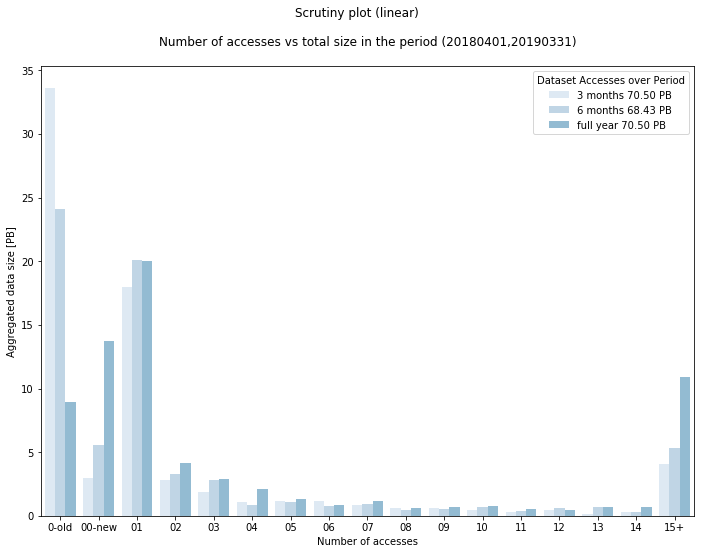

In [157]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.set_palette(sns.color_palette("Blues"))

plot=sns.barplot(x='bin',
                 y='f_size',
                 order=x_order,
                 hue='type',
                 hue_order=values,
                 data=gp,
                 ax=ax)

pyplot.xlabel("Number of accesses")
pyplot.ylabel("Aggregated data size [PB]")
pyplot.suptitle("Scrutiny plot (linear)")
pyplot.title("""
Number of accesses vs total size in the period ({},{})
""".format(start_date, end_date))
plot.legend(title="Dataset Accesses over Period")

In [158]:
sc.stop()

In [159]:
_directory = 'output'
_format = 'pdf'
if not os.path.exists(_directory):
    os.makedirs(_directory)
fig.savefig(os.path.join(_directory,'scrutiny{}-{}.{}'.format(start_date,end_date,_format)),format=_format)